In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import json
import os
import shutil
from pathlib import Path
import os.path
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
def coco_to_yolo_bb(x1, y1, w, h, image_w, image_h):
    #"bbox": [x,y,width,height], (COCO)
    #x_center y_center width height (YOLO)
    return [((2*x1 + w)/(2*image_w)) , ((2*y1 + h)/(2*image_h)), w/image_w, h/image_h]

In [3]:
dataDir='/Users/azakaria/Downloads'
#dataType='val2017'
annFile=f'/Users/azakaria/Downloads/nightowls_validation.json'

In [4]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
cat_map = {}
for i,cat in enumerate(cats):
    cat_map[cat['id']] = i
nms=[cat['name'] for cat in cats]

In [6]:
catIds = coco.getCatIds()

In [7]:
#For viewing in the debugger
#Nice because no prints needed
"""
imgIds = coco.getImgIds()
imgs = coco.loadImgs(ids = imgIds)
annIds = coco.getAnnIds(imgIds=imgIds)
anns = coco.loadAnns(ids = annIds)
"""

'\nimgIds = coco.getImgIds()\nimgs = coco.loadImgs(ids = imgIds)\nannIds = coco.getAnnIds(imgIds=imgIds)\nanns = coco.loadAnns(ids = annIds)\n'

In [19]:
"""
getImgIds() -> list[imgId] 
loadImgs(ids : [imgId]) -> list[img]
getAnnIds(imgIds: list[imgId]) -> list[annId]
loadAnns(ids: list[annId]) -> list[ann]

*One imgId can be multiple annIds
*One annId is one ann


#imgIds need to have annotations and those annotations bboxes must not be negative
#write_label_files need
    #filename, which are in imgs
    #catIds, which are in anns
    #bboxes, which are in anns
"""

def get_img_ids(numImgs):
    imgIds = coco.getImgIds()
    random.shuffle(imgIds)
    imgIds0 = []
    for imgId in imgIds:
        if imgId_has_annotation(imgId) and imgId_has_positive_bboxes(imgId):
            imgIds0.append(imgId)
        if(len(imgIds0) == numImgs):
            break
    return imgIds0

def imgId_has_positive_bboxes(imgId):
    annIds = coco.getAnnIds(imgIds=imgId)
    anns = coco.loadAnns(annIds)
    for ann in anns:
        negative_bbox = False 
        for bbox_val in ann['bbox']:
            if bbox_val < 0:
                negative_bbox = True
        if negative_bbox == True:
            return False
    return True

def imgId_has_annotation(imgId):
    annIds = coco.getAnnIds(imgIds=imgId)
    if(len(annIds) > 0):
        return True
    else:
        return False

imgIds = get_img_ids(120)
print(len(imgIds))

def write_label_files(numImgs):
    """
    Some images:
    *Do not have annotations.
    *Have negative bboxes
    """
    imgIds = get_img_ids(numImgs)

    for imgId in imgIds:
        img = coco.loadImgs(imgId)[0] #If only 1 imgId, len() = 1
        label_dir = Path('/Users/azakaria/Code/openmpf-yolo-training/nightowls/dataset/labels')
        filename = img['file_name'].split('.')[0] + '.txt'
        with open(label_dir/filename, 'w') as file:
            annIds = coco.getAnnIds(imgIds = imgId, catIds=catIds)
            anns = coco.loadAnns(annIds)
            print(len(anns))
            print('-----------------------------')
            #anns = remove_negative_bbox_anns(anns)
            for i,ann in enumerate(anns):
                x_center, y_center, width, height = coco_to_yolo_bb(*ann['bbox'], img['width'], img['height'])
                file.write(f'{cat_map[ann["category_id"]]}\t{x_center}\t{y_center}\t{width}\t{height}\n')
    return

def copy_images_to_dataset_dir(src_image_dir, dest_image_dir, image_extension):
    """
    x number of labels are written to the labels dir by write_label_files(x)
    This function copies the corresponding images into the sibling images dir, completing the dataset folder for YOLO training
    """
    fs = os.listdir('/Users/azakaria/Code/openmpf-yolo-training/nightowls/dataset/labels')
    for f in fs:
        src = str(src_image_dir/f.split('.')[0]) + image_extension
        dest = str(dest_image_dir/ f.split('.')[0]) + image_extension
        #print(src)
        #print(dest)
        #print('----------------')
        if os.path.isfile(src):
            shutil.copyfile(src, dest)
            #/Users/azakaria/Downloads/nightowls_validation.png is not a file
            #print(f'{src} is a file')
        else:
            print(f'{src} is not a file')
    return

#write_label_files(120) #dataset/labels
#copy_images_to_dataset_dir(Path('/Users/azakaria/Downloads/nightowls_validation'),Path('/Users/azakaria/Code/openmpf-yolo-training/nightowls/dataset/images/'), '.png') #dataset/images

#endregion

120


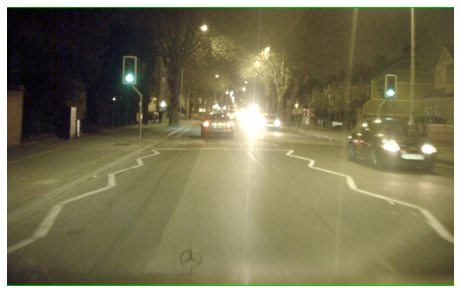

In [18]:
#region useful test code for single imgId
#imgId = 7000058
imgIds = coco.getImgIds()
imgId = imgIds[2]
img = coco.loadImgs(ids = imgId)[0]
annIds = coco.getAnnIds(imgIds = imgId)
anns = coco.loadAnns(annIds)
print(coco)

fp = f'/Users/azakaria/Downloads/nightowls_validation/{img["file_name"]}' 
I = io.imread(fp)
plt.axis('off')
plt.imshow(I)
plt.show()
#endregion

True


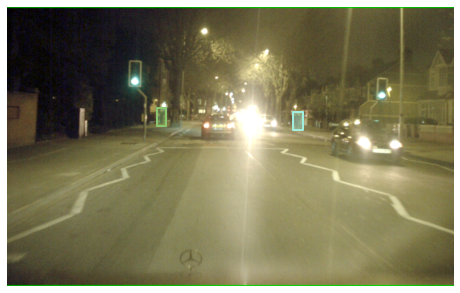

In [17]:
plt.imshow(I); plt.axis('off')
coco.showAnns(anns, draw_bbox=True)

In [46]:
#Commands for workflow
#rm -rf /Users/azakaria/Code/openmpf-yolo-training/nightowls/dataset/images/*; rm -rf /Users/azakaria/Code/openmpf-yolo-training/nightowls/dataset/labels/*
#docker cp /Users/azakaria/Code/openmpf-yolo-training/nightowls/dataset/. 5dcf6e04dbba:/usr/src/datasets/nightowls_val
#ls /Users/azakaria/Code/openmpf-yolo-training/nightowls/dataset/images | wc -l ; ls /Users/azakaria/Code/openmpf-yolo-training/nightowls/dataset/labels | wc -l

/Users/azakaria/Downloads/nightowls_validation.png is not a file
